In [13]:
import pandas as pd
import os
import numpy as np

carpeta_script = 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Experimentos en clase\\Scripts'
carpeta_resultados = 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Experimentos en clase\\Resultados'
carpeta_datos = 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Experimentos en clase\\Datos'


In [14]:
#Carga archivos
sell_in = pd.read_csv(os.path.join(carpeta_datos, 'sell-in.txt'), delimiter = '\t')
tb_productos = pd.read_csv(os.path.join(carpeta_datos, 'tb_productos.txt'), delimiter = '\t')
tb_stocks = pd.read_csv(os.path.join(carpeta_datos, 'tb_stocks.txt'), delimiter = '\t')
productos_predecir = pd.read_csv(os.path.join(carpeta_datos, 'productos_a_predecir.txt'), delimiter = '\t')  

In [15]:
sell_in.head()
productos_predecir.head()

ventas_producto_mes = sell_in.groupby(['periodo', 'product_id'])['tn'].sum()
ventas_producto_mes = ventas_producto_mes.reset_index()


In [16]:
ventas_producto_mes['Timestamp'] = pd.to_datetime(ventas_producto_mes['periodo'], format='%Y%m')
ventas_producto_mes.set_index('Timestamp', inplace=True)
ventas_producto_mes.drop(columns=['periodo'], inplace=True)



In [17]:
from prophet import Prophet

lista_productos_prophet = []
lista_predicciones_dic_prophet = []
lista_valores_reales_dic = []
lista_cantidad_valores = []

for producto in ventas_producto_mes['product_id'].unique():
    if producto in list(productos_predecir['product_id']):
        try:
            ventas_mes_por_producto = ventas_producto_mes[ventas_producto_mes['product_id'] == producto].copy()
            ventas_mes_por_producto.drop(columns=['product_id'], inplace = True)
            valores_entrenamiento = ventas_mes_por_producto[(ventas_mes_por_producto.index != '2019-12-01') & (ventas_mes_por_producto.index != '2019-11-01')]
            valor_real_dic = ventas_mes_por_producto[ventas_mes_por_producto.index == '2019-12-01']
            #Convertimos a formato Prophet
            valores_entrenamiento = valores_entrenamiento.reset_index().rename(columns = {'Timestamp': 'ds', 'tn': 'y'})
            modelo = Prophet()
            modelo.fit(valores_entrenamiento)
            futuro = modelo.make_future_dataframe(periods=2, freq='MS')
            forecast = modelo.predict(futuro)[['ds','yhat']]
            prediccion = forecast[forecast['ds'] == '2019-12-01']['yhat'].values[0]
            lista_productos_prophet.append(producto)
            lista_predicciones_dic_prophet.append(max(prediccion, 0)) #Si la predicción es negativa, se pone 0
            lista_valores_reales_dic.append(valor_real_dic.values[0,0])
            lista_cantidad_valores.append(valores_entrenamiento['y'].count())
        except Exception as e:
            print(f'Error en producto {producto}')
            print(e)
            print('Imprimiendo valores de entrenamiento')
            print(valores_entrenamiento)
            lista_productos_prophet.append(producto)
            lista_predicciones_dic_prophet.append(valores_entrenamiento['y'].mean())
            lista_valores_reales_dic.append(valor_real_dic.values[0,0])
            lista_cantidad_valores.append(valores_entrenamiento['y'].count())

21:24:11 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1] done processing
21:24:11 - cmdstanpy - INFO - Chain [1] start processing
21:24:11 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:12 - cmdstanpy - INFO - Chain [1] done processing
21:24:12 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1] done processing
21:24:13 - cmdstanpy - INFO - Chain [1] start processing
21:24:13 - cmdstanpy - INFO - Chain [1]

In [18]:
resultados_prophet = pd.DataFrame({'product_id': lista_productos_prophet, 'Prediccion': lista_predicciones_dic_prophet, 
                                 'Valor_dic': lista_valores_reales_dic, 'Cantidad_ej_entrenamiento': lista_cantidad_valores})

In [19]:
resultados_prophet.head()

,product_id,Prediccion,Valor_dic,Cantidad_ej_entrenamiento
0,20001,1563.588550,1504.68856,34
1,20002,480.936298,1087.30855,34
2,20003,808.968697,892.50129,34
3,20004,593.606589,637.90002,34
4,20005,689.343718,593.24443,34


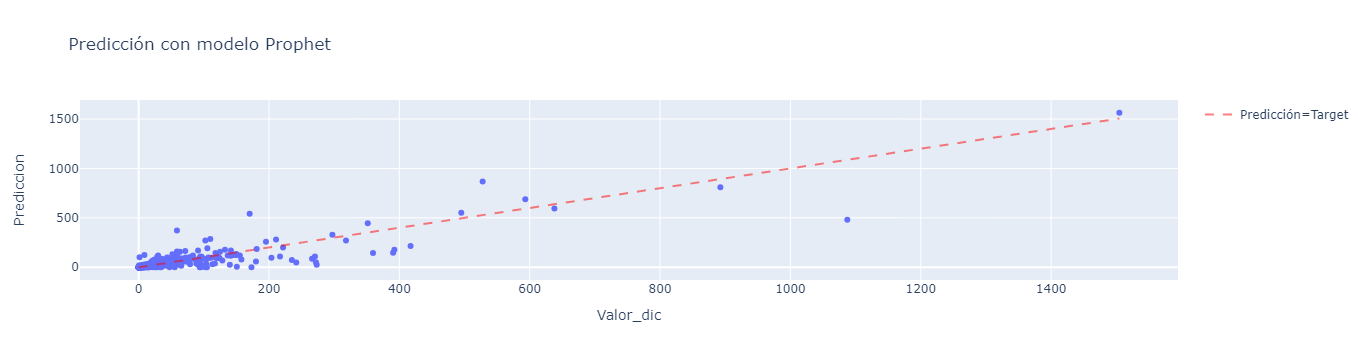

In [20]:
import plotly.graph_objs as go
import plotly.express as px

# Dispersion valores dic vs prediccion
scatter = px.scatter(resultados_prophet, x='Valor_dic', y='Prediccion', title="Predicción con modelo Prophet")

# Add names to each point in the scatter plot
scatter.update_traces(
    hovertext=resultados_prophet['product_id'],
    hovertemplate='<b>Producto:%{hovertext}</b><br>Valor Diciembre: %{x}<br>Predicción: %{y}<extra></extra>',
    mode='markers'
)


# Recta de pendiente 1
line_x = np.linspace(0, max(resultados_prophet['Valor_dic']), 1000)
line_y = line_x

# Agregar línea al plot
scatter.add_trace(go.Scatter(x=line_x, y=line_y, mode='lines', name='Predicción=Target', line=dict(color='red', dash='dash', width=2),opacity=0.5))

#Guardar archivo HTML
scatter.write_html(os.path.join(carpeta_resultados, "Errores_Prophet_pred_diciembre.html"))

# Show the plot
scatter.show()

In [21]:
resultados_prophet['Error_abs'] = np.abs(resultados_prophet['Valor_dic'] - resultados_prophet['Prediccion'])

resultados_prophet.to_excel(os.path.join(carpeta_resultados, "Prediccion_Prophet_Dic.xlsx"), index=False)

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\alope\\Desktop\\Trámites\\Maestria Data Science - Universidad Austral\\Laboratorio de implementación 3\\Experimentos en clase\\Resultados\\Prediccion_Prophet_Dic.xlsx'